<a href="https://colab.research.google.com/github/castudil/som-lstm/blob/main/DTW_SOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias

In [ ]:
!pip install minisom
!pip install DtwSom


In [ ]:
from minisom import MiniSom 
import dtwsom   
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import timeit
import pickle
from math import sqrt


from sklearn.preprocessing import MinMaxScaler # funcion para el escalar los datos
from sklearn.cluster import KMeans

from matplotlib.patches import RegularPolygon, Ellipse
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib.lines import Line2D

# Funciones

In [ ]:
def perturbation(df, col=0, mu=0, sigma=0.1):

  """
    Funcion que perturba una columna de un dataframe, con una cantidad 
    normalmente distribuida con media 0 y desviación típica 0,1 por defecto.

    Parameters
        -----------
        df : DataFrame 
          DataFrame de los datos para perturbar
        col : int
          columna del DataFrame que sera perturbada
        mu: float
          mean
        sigma: float
          desviacion estandar
  """
  np.random.seed(11)
  df = df.copy() # copia el dataframe para evitar que se modifique el dataframe original

  cardinality = df.shape[0] # numero de instancias del dataset

  # Toma muestras aleatorias de una distribución normal
  perturbacion = pd.Series(np.random.normal(loc=mu, scale=sigma, size=cardinality))

  columns_name  = df.columns # nombres de las columnas

  # Suma las muestras aleatorias a la columna seleccionada y pasa esta suma al dataset copiado.
  df[columns_name[col]] = df[columns_name[col]] + perturbacion  

  return df

## Funciones de preprocesamiento

In [ ]:
def filter_data(data):
  filtered_df = pd.DataFrame()
  lista = []
  # filter the dataset between the months of April and August from 2016 to 2020
  for i in range(16,21):
    lista.append(data.loc['20'+str(i)+'-04-1': '20'+str(i)+'-08-31'])

  # consolidating into a single data frame
  filtered_df = pd.concat(lista)

  print(filtered_df.describe())
  print(filtered_df.index.min())
  print(filtered_df.index.max())
  return filtered_df

In [ ]:
def ts_train_test_normalize(all_data, time_steps, for_periods, name_target, start_date_train=None, end_date_train=None, start_date_test=None, end_date_test=None):
    '''
    input: 
      all_data: dataframe 
      time_steps: tamaño de la ventana para obtener una predicción
      for_periods: cantidad de datos a predecir 
      start_date_train: fecha de inicio de los datos de entramiento
      end_date_train: fecha de final de los datos de entramiento
      start_date_test: fecha de inicio de los datos de prueba
      end_date_test: fecha de final de los datos de prueba
    output:
      X_train, y_train: data de [start_date_train - end_date_train]
      X_test:  data de [start_date_test - end_date_test]
      sc:      instancia del objeto MinMaxScaler (Escala los datos de entrenamiento)
    '''


    start_date_train =  start_date_train if start_date_train else all_data.index[0]
    end_date_test =  end_date_test if end_date_test else all_data.index[len(all_data)-1]

    # crear un conjunto de entrenamiento y prueba
    ts_train = all_data[start_date_train : end_date_train].iloc[:,0:1].values
    ts_test  = all_data[start_date_test : end_date_test].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # Escalar los datos en el rango (0,1)
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # Crear datos de entrenamiento de s muestras y t pasos de tiempo
    X_train = []
    y_train = []
    for i in range(time_steps,ts_train_len-1): 
        # Añade la ventana de t pasos de tiempo para el conjunto de entranamiento x
        X_train.append(ts_train_scaled[i-time_steps:i,0])
        # Añade la ventana de t' pasos de tiempo para el conjunto de entranamiento y 
        y_train.append(ts_train_scaled[i:i+for_periods,0])
    # Convierte los datos de entramiento en arreglos de numpy
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reestructura X_train a 3D [samples, timesteps, features]
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    # Escala los datos para el conjunto de datos de prueba 
    inputs = pd.concat((all_data[name_target][start_date_train : end_date_train], all_data[name_target][start_date_test : end_date_test]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1) # Convertir en array cada valor del array. Ex: [1,2,3] -> [[1],[2],[3]]
    inputs  = sc.transform(inputs) # Escala los datos en el rango (0,1)

    # Crea los datos de prueba X_test de s muestras y t pasos de tiempo
    X_test, y_test = [], []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        # Añade la ventana de t pasos de tiempo para el conjunto de prueba X
        X_test.append(inputs[i-time_steps:i,0])
        # Añade la ventana de t' pasos de tiempo para el conjunto de prueba y
        y_test.append(inputs[i:i+for_periods,0])
    # Convierte los datos de prueba en arreglos de numpy
    X_test, y_test = np.array(X_test), np.array(y_test)

    # Reestructura X_test a 3D [samples, timesteps, features]
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, y_test, sc

#Dataset PM25

In [ ]:
path = 'https://raw.githubusercontent.com/castudil/som-lstm/main/data/' # use your path
cities = ['chillan','curico','linares','los_angeles','osorno','puerto_montt','rancagua','san_fernando','talca'];
li = []
for i in cities:
  filename=path+i+'.csv'
  print('loading: '+filename)
  df = pd.read_csv(filename, index_col=None, header=0)
  # Convert the date column to a datestamp type
  df['date'] = pd.to_datetime(df['date'])
  # Set the date column as the index of your DataFrame meat
  df['city']=i
  df = df.set_index('date')
  #print(df.head(5))
  li.append(df)

print('consolidating into a single data frame.')
frame = pd.concat(li, axis=0, ignore_index=False)
print('displaying a random sample.')
print(frame.sample(n = 15))
print(frame.describe())
#print(frame['date'].dt.date.min()+ ' to '+ frame['date'].dt.date.max())
print(frame.index.min())
print(frame.index.max())

loading: https://raw.githubusercontent.com/castudil/som-lstm/main/data/chillan.csv
loading: https://raw.githubusercontent.com/castudil/som-lstm/main/data/curico.csv
loading: https://raw.githubusercontent.com/castudil/som-lstm/main/data/linares.csv
loading: https://raw.githubusercontent.com/castudil/som-lstm/main/data/los_angeles.csv
loading: https://raw.githubusercontent.com/castudil/som-lstm/main/data/osorno.csv
loading: https://raw.githubusercontent.com/castudil/som-lstm/main/data/puerto_montt.csv
loading: https://raw.githubusercontent.com/castudil/som-lstm/main/data/rancagua.csv
loading: https://raw.githubusercontent.com/castudil/som-lstm/main/data/san_fernando.csv
loading: https://raw.githubusercontent.com/castudil/som-lstm/main/data/talca.csv
consolidating into a single data frame.
displaying a random sample.
                        PM25          city
date                                      
2017-08-17 08:00:00   22.000        osorno
2018-01-04 13:00:00    3.000  san_fernando
20

In [ ]:
# filtered for city
df = frame.loc[frame['city'] == 'talca']
del(df['city'])
leaked_data = filter_data(df)

               PM25
count  18360.000000
mean      28.361704
std       35.043856
min        0.000000
25%        8.000000
50%       18.920000
75%       36.490000
max      714.898000
2016-04-01 00:00:00
2020-08-31 23:00:00


In [ ]:
leaked_data

,PM25
date,
2016-04-01 00:00:00,8.10999
2016-04-01 01:00:00,8.10999
2016-04-01 02:00:00,5.40500
2016-04-01 03:00:00,5.40500
2016-04-01 04:00:00,8.10999
...,...
2020-08-31 19:00:00,7.00000
2020-08-31 20:00:00,13.00000
2020-08-31 21:00:00,14.00000


In [ ]:
print(leaked_data.values[0:24].reshape(1,24)[0])

[ 8.10999  8.10999  5.405    5.405    8.10999 17.57     8.10999  8.90999
  8.15999  8.85999 10.81    12.16    12.16    17.57    25.68    13.51
  9.45998 18.96    18.91    19.64    17.57    16.21    10.86    12.16   ]


In [ ]:
leaked_data.values[24]

array([20.27])

In [ ]:
data_pm25 = []
for i in range(0, int(df.size /24) ):
  data_pm25.append(df.values[i*24:i*24+24].reshape(1,24)[0])


In [ ]:
## The Multivariate DTW-SOM was designed to take input data in shape of (n, k, t)
## n is the number of data records, k is the number of variables, t is the number of timestamps
data_all_new = np.array(data_pm25)

In [ ]:
data_all_new.shape

(1826, 24)

In [ ]:
len(data_all_new[0])

24

#Inicializacion de parametros para SOM

Explicar la expresión (MiniSOM) (enlace a papers, codigo tutoriales)

In [ ]:
round(sqrt(5*sqrt(len(data_all_new))))

15

In [ ]:
# Inicializa los parametros de SOM
num_neurons = round(sqrt(5*sqrt(len(data_all_new))))
m_neurons = 12
sigma = 3 # radio
lr = 0.5 # tasa de aprendizaje
num_features = 1 # numero de caracteristicas
dist = 'euclidean' # Distancia utilizada 
neighborhood_funct = 'gaussian' # funcion de vencidad 
seed = 11 # semilla para repetir los resultados
num_iter = 5000 # numero de iteraciones para entrenar al SOM
input_len = data_all_new.shape[1] #Largo de la entrada

#DTW-SOM

In [ ]:
som = dtwsom.DtwSom(num_neurons, num_neurons, input_len, sigma=sigma, learning_rate=lr,
                    random_seed=seed, gl_const="sakoe_chiba", scr=60)
som.pca_weights_init(data_all_new)
som.train_batch(data_all_new, num_iter, verbose=True)
weights = som.get_weights()

 [ 5000 / 5000 ] 100% - 5.92 it/s - 0:00:00 left  - quantization error: 28.383497293500344


In [ ]:
print("cuantificacion del error: ",som.quantization_error(data_all_new))

cuantificacion del error:  28.383497293500344


In [ ]:
## Save the model so that you do not need to train it again
with open('som.pkl', 'wb') as f:
    pickle.dump(som,f)

In [ ]:
np.array(weights)[0,0]

array([1.75325104, 1.65212317, 1.5436893 , 1.48547284, 1.09667785,
       1.06551999, 1.05305671, 1.1142377 , 1.02000618, 1.07272827,
       1.90880479, 2.78870403, 4.13154388, 7.04101745, 3.1803583 ,
       1.1394057 , 1.00865154, 1.00967091, 1.05799581, 1.20461398,
       1.18126804, 1.03230743, 1.03477343, 1.57977335])

In [ ]:
KMeans_X = np.stack((np.array(weights)).reshape(num_neurons*num_neurons, 24))
KMeans_all = KMeans(n_clusters=4, random_state=0).fit(KMeans_X)
KMeans_all.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 2, 2,
       2, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       3, 3, 3, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       3, 3, 3, 3, 3], dtype=int32)

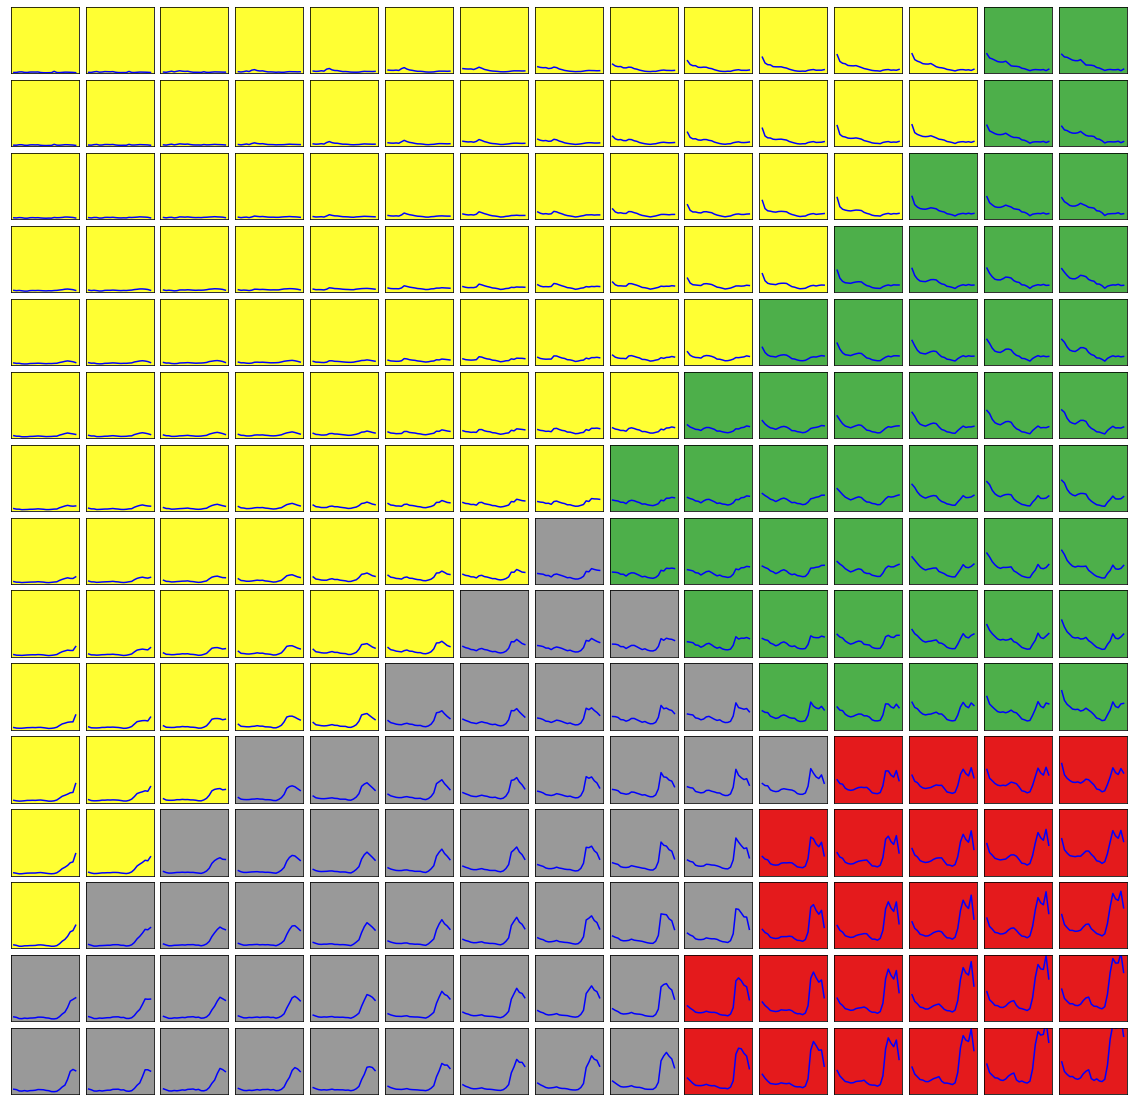

In [ ]:
plt.figure(figsize=(20, 20))
norm = Normalize(vmin=0, vmax=3, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Set1_r)
for i in range(num_neurons):
    maxylim= np.max(data_all_new)
    for j in range(num_neurons):
        ax = plt.subplot(num_neurons, num_neurons, i*num_neurons + 1+j)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_ylim((0,maxylim/5))
        plt.plot(np.array(weights)[ i, j, :], color= 'blue')
        ax.set_facecolor(mapper.to_rgba(KMeans_all.labels_[i*num_neurons +j]))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

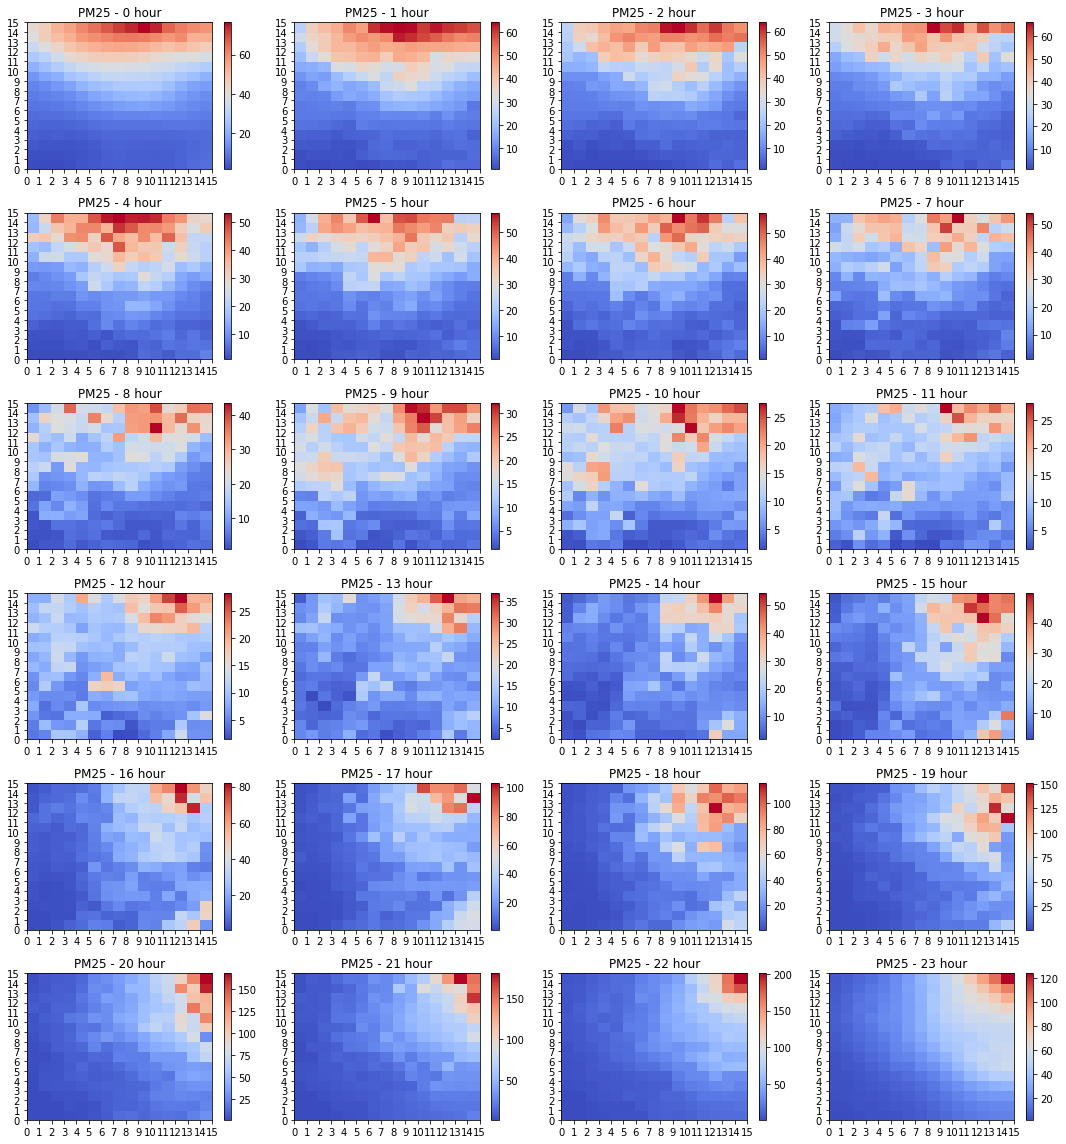

In [ ]:
plt.figure(figsize=(15, 16))

for i in range(24):
    plt.subplot(6, 4, i+1)
    plt.title("PM25 " +"- "+str(i)+" hour")
    plt.pcolor(weights[:,:,i].T, cmap='coolwarm')
    plt.colorbar()
    plt.xticks(np.arange(num_neurons+1))
    plt.yticks(np.arange(num_neurons+1))
plt.tight_layout()
plt.show()

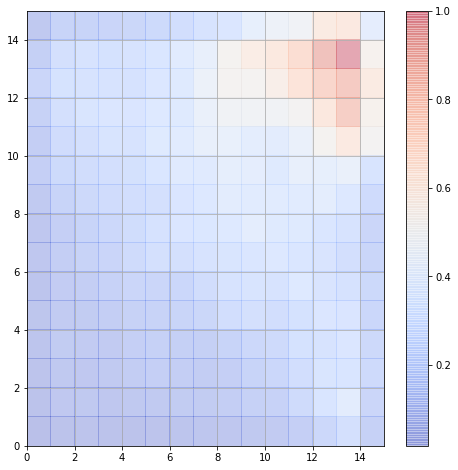

In [ ]:
plt.figure(figsize=(8, 8))
plt.pcolor(som.distance_map().T, cmap='coolwarm', alpha=.35)
plt.colorbar()

colors = ['C3', 'C2', "C1"]

#plt.legend(loc='upper right')
plt.grid()
#plt.savefig('resulting_images/som_seed.png')
plt.show()

# SOM - standard

In [ ]:
# Inicializa SOM
som_standard =dtwsom.MiniSom(num_neurons, num_neurons, input_len, sigma=sigma, learning_rate=lr,
                    random_seed=seed)
som_standard.pca_weights_init(data_all_new)
som_standard.train_batch(data_all_new, num_iter, verbose=True) # Entrada SOM
weights = som_standard.get_weights() # Obtiene los pesos

#print("Error topologico: ",som_standard.topographic_error(data))


 [ 5000 / 5000 ] 100% - 1816.72 it/s - 0:00:00 left  - quantization error: 42.13894419258603


In [ ]:
print("cuantificacion del error: ",som_standard.quantization_error(data_all_new))

cuantificacion del error:  42.13894419258603


In [ ]:
## Save the model so that you do not need to train it again
with open('som_standard.pkl', 'wb') as f:
    pickle.dump(som_standard,f)

# Pruebas

Experimento 1 : 
* Paso 1: tomar una instacia x y generar m mutantes,
* Paso 2: Identificar la neurona que representa a a la instacia x.
* paso 3: Para cada mutante hacer : Identificar a la neurona que representa a la mutante.
* Paso 4: El error es igual a la distancia que existe entre la neurona que representa a x y la neurona que representa a la mutante.
* Paso 5: reportar el error acumulado
 
 Comporar SOm y DTW-SOM usando experimento 1

 Supuesto preliminar:

 * DTW_SOM tiene menos error 
 * La estadistica representa a mas de x. 
